
 <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению

    
Автор материала: Ольга Дайховская (@aiho в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

#  Домашнее задание № 4 (демо).
## Прогнозирование популярности статей на TechMedia (Хабр) с помощью линейных моделей
    
**В задании Вам предлагается разобраться с тем, как работает TfidfVectorizer и DictVectorizer, затем обучить и настроить модель линейной регрессии Ridge на данных о публикациях на Хабрахабре. Пройдя все шаги, вы сможете получить бейзлайн для [соревнования](https://www.kaggle.com/c/howpop-habrahabr-favs-lognorm) (несмотря на old в названии, для этого задания соревнование актуально). 
Ответьте на все вопросы в этой тетрадке и заполните ответы в [гугл-форме](https://docs.google.com/forms/d/1gPt401drm84N2kdezwGWtPJN_JpaFqXoh6IwlWOslb4).**

**Описание соревнования**

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

**Приступим:** импортируем необходимые библиотеки и скачаем данные

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
from matplotlib import pyplot as plt

Скачайте [данные](https://drive.google.com/file/d/1nV2qV9otN3LnVSDqy95hvpJdb6aWtATk/view?usp=sharing) соревнования (данные были удалены с Kaggle ради организации последующего идентичного соревнования, так что тут ссылка на Google Drive).

In [2]:
# при необходимости поменяйте путь к данным 
train_df = pd.read_csv('howpop_train.csv')
test_df  = pd.read_csv('howpop_test.csv')

In [42]:
train_df.head(10)

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm,year
0,https://habrahabr.ru/post/18284/,habrahabr.ru,18284,2008-01-01 18:19:00,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,0,0,236,0.0,0.0,-0.792687,-1.344075,-2.436871,2008
1,https://habrahabr.ru/post/18285/,habrahabr.ru,18285,2008-01-01 18:30:00,@DezmASter,design,False,7344,"Сумасшедшие яйца, или сервис для отслеживания ...",1,1,353,1.0,0.0,-0.485214,-0.831946,-1.873193,2008
2,https://habrahabr.ru/post/18286/,habrahabr.ru,18286,2008-01-01 18:34:00,@DezmASter,design,False,8431,"Сумасшедшие яйца, или сервис для отслеживания ...",47,72,1200,45.0,5.0,0.446090,1.794023,0.574656,2008
3,https://habrahabr.ru/post/18291/,habrahabr.ru,18291,2008-01-02 01:32:00,@Taoorus,design,False,5662,"Сглаживание шрифтов, и субпиксельная отрисовка",102,36,5700,72.0,3.0,1.627469,1.300050,1.167375,2008
4,https://geektimes.ru/post/18294/,geektimes.ru,18294,2008-01-02 14:34:00,@dennydo,NaN,False,3706,Почему мне не нравится iPhone,230,6,1400,73.0,15.0,1.362397,0.961094,2.020356,2008
5,https://habrahabr.ru/post/18295/,habrahabr.ru,18295,2008-01-02 16:14:00,@lvea,develop,False,3171,Mobile2.0 Всеобщая доступность,22,1,192,9.0,2.0,-0.950075,-0.825149,0.016555,2008
6,https://geektimes.ru/post/18306/,geektimes.ru,18306,2008-01-03 12:55:00,@abbasov,NaN,False,435,Modbook в действии,10,0,301,5.0,1.0,-0.402140,-1.278643,-0.355525,2008
7,https://habrahabr.ru/post/18311/,habrahabr.ru,18311,2008-01-03 17:20:00,@Andrey,misc,False,3291,В чем суть проекта Vladelia.ru,64,1,141,17.0,20.0,-1.168569,-0.822414,0.801626,2008
8,https://habrahabr.ru/post/31352/,habrahabr.ru,31352,2008-01-03 22:54:00,@kvladimir,develop,False,1953,Подтверждено: Wikia Search запускается в понед...,23,2,208,21.0,3.0,-0.878984,-0.525245,0.041000,2008
9,https://habrahabr.ru/post/18314/,habrahabr.ru,18314,2008-01-03 23:56:00,@lvea,develop,False,3712,Mobile 2.0 Выбор предпочтительного способа связи,6,1,401,2.0,0.0,-0.389766,-0.817507,-0.896510,2008


In [4]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Убедимся, что данные отсортированы по признаку `published`

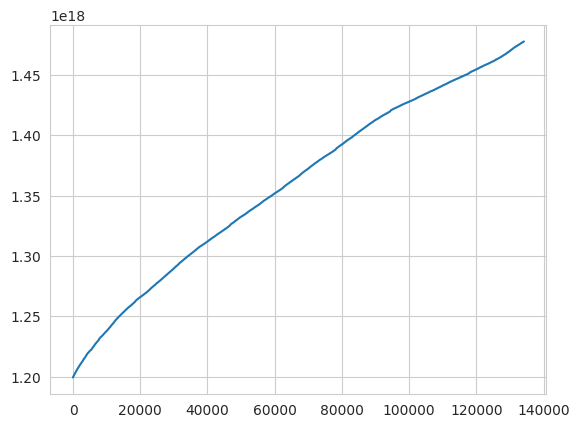

In [5]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

**Чтобы ответить на вопросы 1 и 2, можно использовать [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), [pandas.to_datetime()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) и [pandas.Series.value_counts()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html)**

<font color='red'>Вопрос 1.</font> Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)
- да
- нет
- не знаю

In [6]:
# ваш код здесь
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   url               134137 non-null  object 
 1   domain            134137 non-null  object 
 2   post_id           134137 non-null  int64  
 3   published         134137 non-null  object 
 4   author            97657 non-null   object 
 5   flow              97048 non-null   object 
 6   polling           134137 non-null  bool   
 7   content_len       134137 non-null  int64  
 8   title             134137 non-null  object 
 9   comments          134137 non-null  int64  
 10  favs              134137 non-null  int64  
 11  views             134137 non-null  int64  
 12  votes_plus        133566 non-null  float64
 13  votes_minus       133566 non-null  float64
 14  views_lognorm     134137 non-null  float64
 15  favs_lognorm      134137 non-null  float64
 16  comments_lognorm  13

In [7]:
train_df.drop('post_id', axis=1).corr()

/tmp/ipykernel_989/1952369581.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df.drop('post_id', axis=1).corr()


,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
polling,1.000000,-0.003337,0.042605,0.006882,0.025660,-0.033505,0.027116,-0.003523,-0.036385,0.071417
content_len,-0.003337,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132
comments,0.042605,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740
favs,0.006882,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239
views,0.025660,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.033505,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081
votes_minus,0.027116,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458
views_lognorm,-0.003523,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530
favs_lognorm,-0.036385,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476
comments_lognorm,0.071417,0.073132,0.662740,0.263239,0.326427,0.525081,0.355458,0.546530,0.479476,1.000000


/tmp/ipykernel_989/2569711181.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr())


<AxesSubplot: >

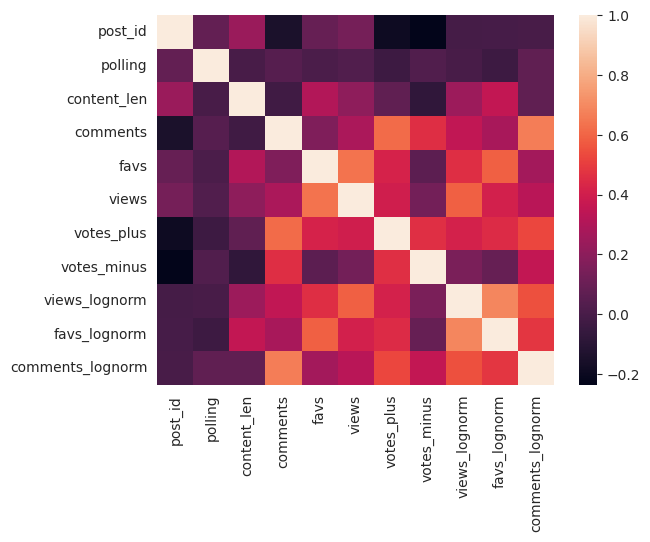

In [8]:
sns.heatmap(train_df.corr())

<font color='red'>Вопрос 2.</font> В каком году было больше всего публикаций? (Рассматриваем train_df)
- 2014
- 2015
- 2016
- 2017

<AxesSubplot: xlabel='year', ylabel='count'>

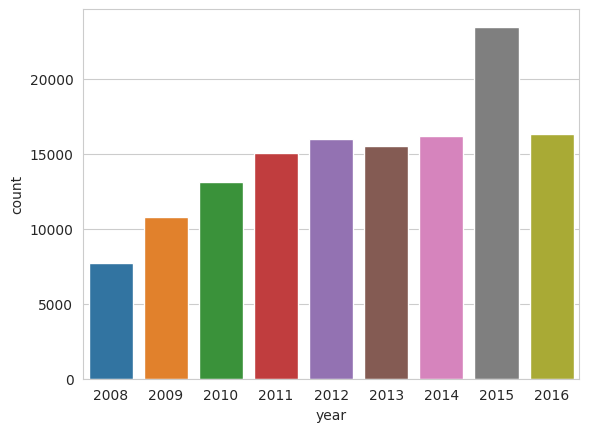

In [9]:
# ваш код здесь
train_df.published = pd.to_datetime(train_df.published, yearfirst=True)  # переводим из object в datetime64
train_df['year'] = [d.year for d in train_df.published]  # добавляем столбец год
sns.countplot(data=train_df, x=train_df.year)  # на гистограмме видно, что больше всего публикаций было в 2015 году

## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [10]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [11]:
len(train_df), train_size

(134137, 93895)

In [12]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.loc[:, features]

In [13]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

## Применение TfidfVectorizer

**TF-IDF** (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции. [Подробнее в источнике](https://ru.wikipedia.org/wiki/TF-IDF)

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

**Основные параметры TfidfVectorizer в sklearn:**
- **min_df** - при построении словаря слова, которые встречаются *реже*, чем указанное значение, игнорируются
- **max_df** - при построении словаря слова, которые встречаются *чаще*, чем указанное значение, игнорируются
- **analyzer** - определяет, строятся ли признаки по словам или по символам (буквам)
- **ngram_range** - определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов.
- **stop_words** - слова, которые игнорируются при построении матрицы

Более подробно с параметрами можно ознакомиться в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

**Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 3.</font> Какой размер у полученного словаря?
- 43789
- 50624
- 93895
- 74378

In [14]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1,3))  # ваш код здесь

X_train_title = vectorizer_title.fit_transform(X_train.title)# и здесь
X_valid_title = vectorizer_title.transform(X_valid.title)# и тут тоже
X_test_title = vectorizer_title.transform(X_test.title)# и тут

In [15]:
print(X_train_title.shape)
print(X_valid_title.shape)
print(X_test_title.shape)

(93895, 50624)
(40242, 50624)
(3990, 50624)


In [16]:
# Можно посмотреть словарь в виде {'термин': индекс признака,...}
vectorizer_title.vocabulary_['python']

9065

In [17]:
X_train_title.shape  # ваш код здесь

(93895, 50624)

<font color='red'>Вопрос 4.</font> Какой индекс у слова 'python'?
- 1
- 10
- 9065
- 15679

In [18]:
vectorizer_title.get_feature_names_out() # ваш код здесь

array(['00', '00 msk', '00 мск', ..., 'ящиков', 'ёлка', 'ёлку'],
      dtype=object)

**Инициализируйте TfidfVectorizer, указав analyzer='char'.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 5.</font> Какой размер у полученного словаря?
- 218
- 510
- 125
- 981

In [19]:
vectorizer_title_ch = TfidfVectorizer(analyzer='char')  # ваш код здесь

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train.title)  #...
X_valid_title_ch = vectorizer_title_ch.transform(X_valid.title)  #...
X_test_title_ch = vectorizer_title_ch.transform(X_test.title)  #...

In [20]:
print(X_train_title_ch.shape)
print(X_valid_title_ch.shape)
print(X_test_title_ch.shape)

(93895, 218)
(40242, 218)
(3990, 218)


In [21]:
# Здесь так же можно посмотреть словарь
# Заметьте насколько отличаются словари для TfidfVectorizer с analyzer='word' и analyzer='char'
len(vectorizer_title_ch.vocabulary_)

218

In [22]:
# ваш код здесь

## Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [23]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Рассмотрим как он работает на примере первых пяти строк

In [24]:
# сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [25]:
# Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
# а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [26]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
# поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [27]:
# В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [28]:
# Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [29]:
# В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
# Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

Посмотрим сколько уникальных значений в каждой колонке.<br />
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [30]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


Также можно посмотреть что означает каждая колонка полученной матрицы

In [31]:
# например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

**Инициализируйте DictVectorizer с параметрами по умолчанию.<br />
Примените метод fit_transform к X_train[feats] и метод transform к X_valid[feats] и X_test[feats]**

In [32]:
vectorizer_feats = DictVectorizer()  #ваш код здесь

X_train_feats = vectorizer_feats.fit_transform(X_train[feats].fillna('-').T.to_dict().values()) #...
X_valid_feats = vectorizer_feats.transform(X_valid[feats].fillna('-').T.to_dict().values())  #...
X_test_feats = vectorizer_feats.transform(X_test[feats].fillna('-').T.to_dict().values())  #...

In [33]:
print(X_train_feats.shape)
print(X_valid_feats.shape)
print(X_test_feats.shape)

(93895, 17869)
(40242, 17869)
(3990, 17869)


Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [34]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

In [35]:
print(X_train_new.shape)
print(X_valid_new.shape)
print(X_test_new.shape)

(93895, 68711)
(40242, 68711)
(3990, 68711)


## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.
[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Основной параметр Ridge - **alpha, коэффициент регуляризации**. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

**Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1**

**Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.**

<font color='red'>Вопрос 6.</font> Выберите верные утверждения:
- обе модели показывают одинаковый результат (среднеквадратичная ошибка отличается не больше чем на тысячные), регуляризация ничего не меняет
- при alpha=0.1 модель переобучается
- среднеквадратичная ошибка первой модели на тесте меньше
- при alpha=1.0 у модели обобщающая способность лучше, чем у при alpha=0.1

In [36]:
%%time
model1 = Ridge(alpha=0.1, random_state=1)  #ваш код здесь
model1.fit(X_train_new, y=y_train)  #здесь тоже ваш код

CPU times: user 14.4 s, sys: 45.6 s, total: 1min
Wall time: 7.98 s


Ridge(alpha=0.1, random_state=1)

In [37]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y, train_preds1))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds1))

Ошибка на трейне 0.18466609185064045
Ошибка на тесте 0.9027441207828327


In [38]:
%%time
model2 = Ridge(alpha=1.0, random_state=1)#ваш код здесь
model2.fit(X_train_new, y=y_train)#здесь тоже ваш код

CPU times: user 6.76 s, sys: 22.2 s, total: 29 s
Wall time: 3.84 s


Ridge(random_state=1)

In [39]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds2))

Ошибка на трейне 0.28673741862294905
Ошибка на тесте 0.7010568971783074


## Baseline

**Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.**

In [50]:
%%time
model = Ridge()  # ваш код здесь

# обучите модель на всех данных
X_last = scipy.sparse.vstack([X_train_new, X_valid_new])

model.fit(X_last, y=y)

CPU times: user 10.1 s, sys: 32.1 s, total: 42.2 s
Wall time: 6.3 s


Ridge()

In [49]:
print(y_train.shape)
print(y_valid.shape)
print(y.shape)

(93895,)
(40242,)
(134137,)


In [51]:
test_preds = model.predict(X_test_new)

In [57]:
sample_submission = pd.read_csv('habr_sample_submission.csv',
                                index_col='url')

In [58]:
sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [63]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
# это будет бейзлайн "Простое решение"
# ridge_submission.to_csv('ridge_baseline.csv')
y_test = sample_submission['favs_lognorm']

In [64]:
mean_squared_error(y_test, test_preds)

0.595451499038441